# BioSig-BandVAE: Bandpass-Driven Variational Autoencoder for Interpretable and Compressed Biosignal Feature Generation

In [13]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.BioSigBandVAE_MultiM_Exp import *
from Utilities.Utilities import *


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

#### Env setting

In [14]:
SavePath = './Results/'
ModelName = 'SigBandRep_MultMod_Dia_Z5_Exp.hdf5'

### Model related parameters
LatDim = 5
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1
Capacity_Z = 0.1
Capacity_Fc = 0.1
FcLimit = 0.05
DecayH = 0. 
DecayL = 0.

### Other parameters
Patience = 300
TrRate = 0.8

if not os.path.exists(SavePath):
    os.mkdir(SavePath)

### Model checkpoint
ModelSaveName = SavePath+ModelName

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=Patience)

### Data

In [15]:
DATA = np.load('./Data/AsanTRSet.npy')
SigDim = DATA.shape[1]

np.random.seed(7)
PermutedDATA = np.random.permutation(DATA)
TrLen = int(PermutedDATA.shape[0] * TrRate)

TrData = PermutedDATA[:TrLen]
ValData = PermutedDATA[TrLen:]

### Post model

In [44]:
# Defining BioSigBandVAE
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=400)

## Model core parts
EncInp =EncModel.input
InpZ = EncModel.output[2]
InpFCCommon = EncModel.output[1][:, :2]
InpFCEach = EncModel.output[1][:, 2:]

## Each output of each model
FeatExtOut = FeatExtModel(EncModel.output[:2])
FeatGenOut = FeatGenModel([InpFCCommon, InpFCEach, InpZ])
ReconOut_ext = ReconModel([FeatExtOut,EncModel.output[1]])
ReconOut_gen = ReconModel([FeatGenOut,EncModel.output[1]])

### Define the total model
SigBandRepModel = Model(EncInp, [FeatGenOut, ReconOut_ext, ReconOut_gen])

### Weight controller; Apply beta and capacity 
Beta_Z = Lossweight(name='Beta_Z', InitVal=0.05)(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc', InitVal=0.05)(FeatGenOut)
Beta_Rec_ext = Lossweight(name='Beta_Rec_ext', InitVal=500.)(FeatGenOut)
Beta_Rec_gen = Lossweight(name='Beta_Rec_gen', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)

### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()

ReconOut_ext = Beta_Rec_ext * MSE(ReconOut_ext, EncInp)
SigBandRepModel.add_loss(ReconOut_ext)
SigBandRepModel.add_metric(ReconOut_ext, 'ReconOut_ext')

ReconOut_gen = Beta_Rec_gen * MSE(ReconOut_gen, EncInp)
SigBandRepModel.add_loss(ReconOut_gen)
SigBandRepModel.add_metric(ReconOut_gen, 'ReconOut_gen')

### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatLossWei = tf.concat([ tf.reduce_max(tf.abs(i ), keepdims=True) for i in FeatExtOut], axis=0)
FeatLossWei = tf.reduce_max(FeatLossWei+1e-7) / (FeatLossWei+1e-7)
WeigFeatGenOut = [FeatGenOut[num] * i  for num, i in enumerate (FeatLossWei)]
WeigFeatExtOut = [FeatExtOut[num] * i  for num, i in enumerate (FeatLossWei)]

FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mu').output, SigBandRepModel.get_layer('Z_Log_Sigma').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FC_Mu').output 
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)

SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')

### Load weights
SigBandRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigBandRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_Rec_ext','Beta_Rec_gen', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigBandRepModel.compile(optimizer='adam') 



In [66]:
SigBandRepModel.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_42 (TFOpLambda) (None, 10, 100)      0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
dense_174 (Dense)               (None, 10, 50)       5050        tf.signal.frame_42[0][0]         
__________________________________________________________________________________________________
bidirectional_72 (Bidirectional (None, 10, 60)       14760       dense_174[0][0]                  
____________________________________________________________________________________________

#### Model evaluation

In [67]:
SigBandRepModel.evaluate(TrData,  batch_size=3500, verbose=1)

26/92 [=======>......................] - ETA: 3:07 - loss: 1.6993 - ReconOut_ext: 0.0017 - ReconOut_gen: 0.0017 - FeatRecLoss: 0.0011 - kl_Loss_Z: 0.7186 - kl_Loss_FC: 0.9780


KeyboardInterrupt



In [45]:
N_Exp = 100

Z_pred = np.tile(np.zeros(LatDim), (N_Exp,1))
Z_pred[:,0] = 1
Z_pred[:,1] = -1.
Z_pred[:,2] = -0
#Z_pred = np.linspace(-0.5, 0.5, N_Exp*LatDim).reshape(N_Exp, -1)
FC_Comm = np.tile(np.linspace(0.,0.05, N_Exp )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Exp )[:, None], (1,4))
'''

Z_pred = np.linspace(-5., 5., N_Exp*LatDim).reshape(N_Exp, -1)
FC_Comm = np.tile(np.ones(2) * 0.01, (N_Exp,1))
FC_Each = np.tile(np.ones(4) * 0.01, (N_Exp,1))
'''

#FC_Comm = np.random.uniform(0,1, N_Exp * 2).reshape(N_Exp, -1)
#FC_Each = np.random.uniform(0,1, N_Exp * 4).reshape(N_Exp, -1)

FeatGen = FeatGenModel([FC_Comm,FC_Each, Z_pred])
PredFCs = np.concatenate([FC_Comm,FC_Each], axis=-1)
SigGen = ReconModel([FeatGen, PredFCs])




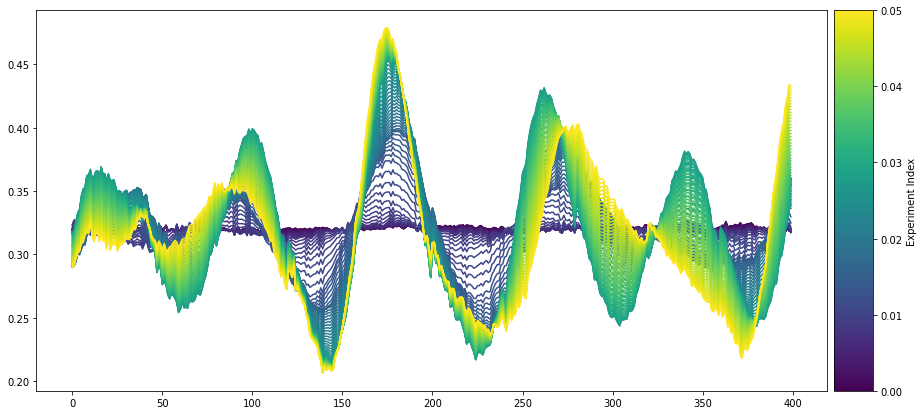

In [50]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a colormap and normalize it based on the number of experiments
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, N_Exp-1)
norm2 = plt.Normalize(0, 0.05)


fig, ax = plt.subplots(figsize=(15, 7))
for i in range(0, N_Exp):
    color = cmap(norm(i))
    ax.plot(FeatGen[3][i], color=color)
    #plt.plot(FeatGen[3][i], label=str(FC_Comm[i, 0]))

# Create color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Experiment Index')

plt.show()

In [57]:
N_Exp = 3
FCTmp= np.linspace(0.,0.05, N_Exp)

FCa, FCb, FCc, FCd, FCe, FCf = np.meshgrid(FCTmp, FCTmp, FCTmp, FCTmp,  FCTmp,  FCTmp)
FC_Comm = np.concatenate([FCa.ravel()[:, None], FCb.ravel()[:, None]], axis=1)
FC_Each = np.concatenate([FCc.ravel()[:, None], FCd.ravel()[:, None], FCe.ravel()[:, None], FCf.ravel()[:, None]   ], axis=1)

Z_pred = np.tile(np.zeros(LatDim), (FC_Comm.shape[0],1))
FeatGen = FeatGenModel([FC_Comm, FC_Each,  Z_pred])



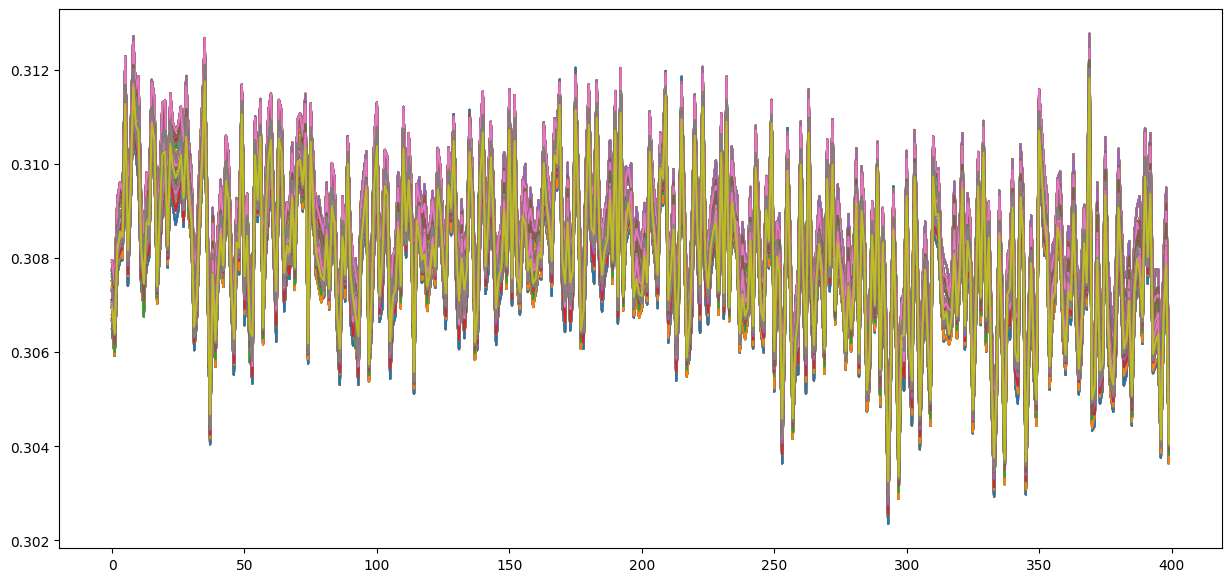

In [58]:
fig, ax = plt.subplots(figsize=(15, 7))

for i in range(0, Z_pred.shape[0]):
    plt.plot(FeatGen[3][i])

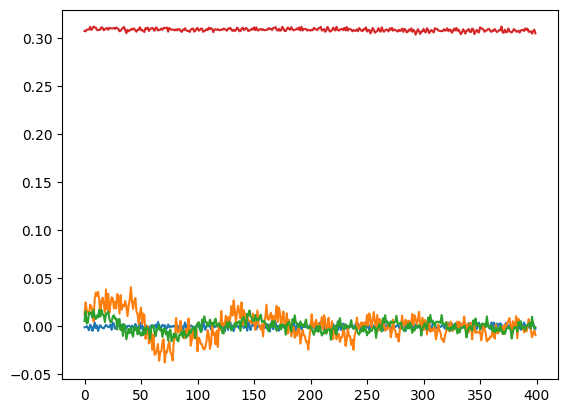

In [59]:
plt.plot(FeatGen[0][10])
plt.plot(FeatGen[1][10])
plt.plot(FeatGen[2][10])
plt.plot(FeatGen[3][0])

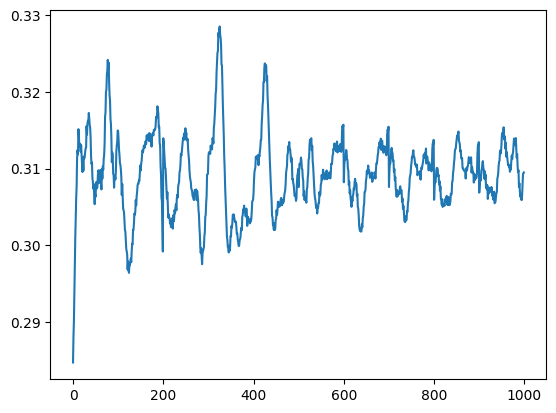

In [60]:
plt.plot(SigGen[70])

In [12]:
PredFCs = FeatExtModel([ValData[2:3], np.array([0.45,0.05,0.45,0.05,0.4,0.1])[None]])

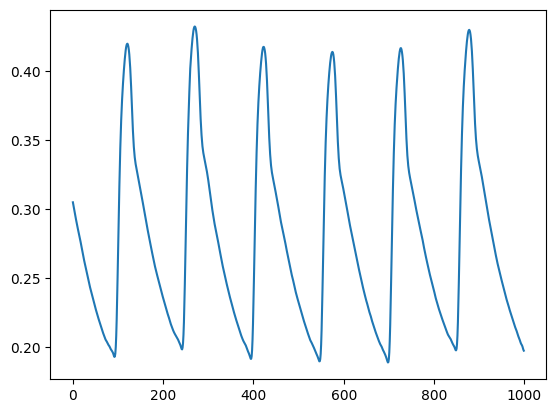

In [21]:
plt.plot(ValData[2:3][0])


In [19]:
SigBandRepModel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 10, 100)      0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10, 50)       5050        tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 60)       14760       dense[0][0]                      
____________________________________________________________________________________________